Research Question: Investigate inequities between NDVI values in white and minority nieghborhoods in Philadelphia. 


Group counts:
Majority white: 127
Majority black: 140
Majority asian: 1
Majority latino: 23

Correlation NDVI vs % White: r=0.052, p=0.3207


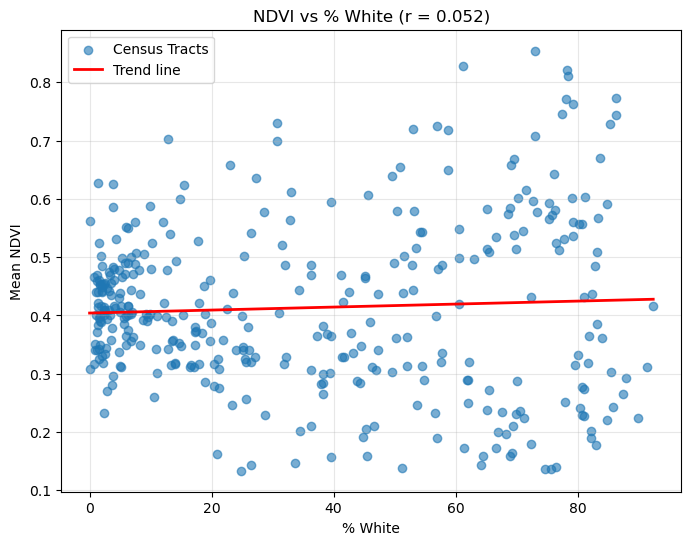


Correlation NDVI vs % Black: r=0.080, p=0.1277


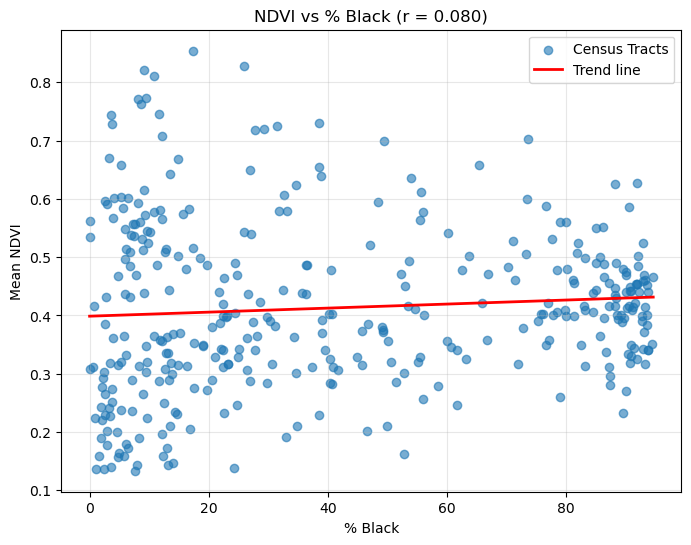


Correlation NDVI vs % Asian: r=-0.263, p=0.0000


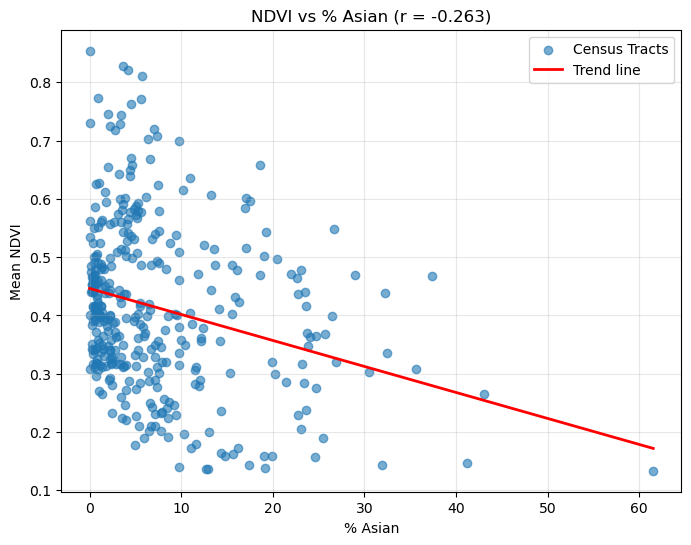


Correlation NDVI vs % Latino/Hispanic: r=-0.139, p=0.0081


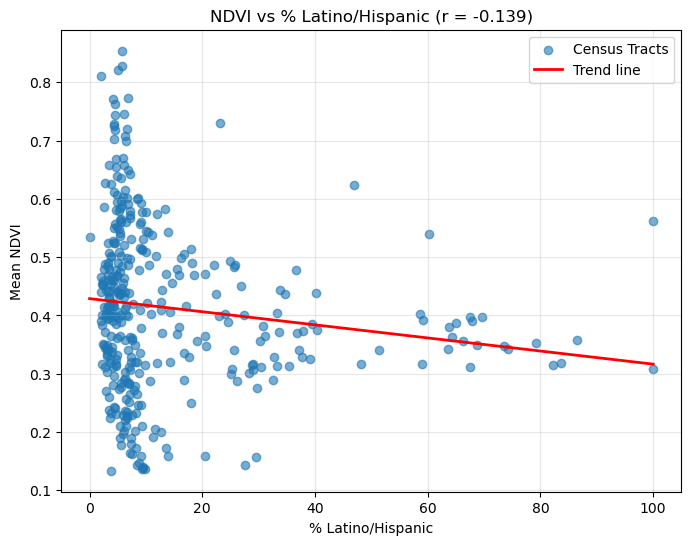

/tmp/ipykernel_9516/922597952.py:183: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


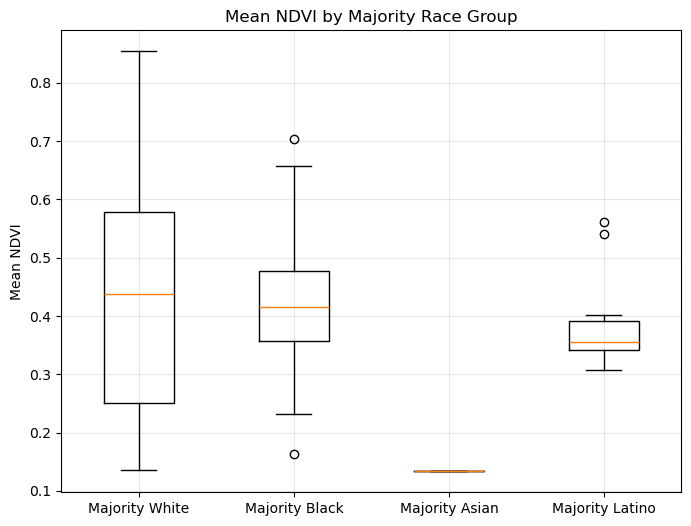

In [1]:

import os
import glob
import json
import requests

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt

from shapely.geometry import mapping
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Census Tracts
# Found this at https://opendataphilly.org/datasets/census-tracts/ 
tract_path = "/workspaces/04-vegetation-charliewrede/Census_Tracts_2010.geojson"

tracts = gpd.read_file(tract_path)
tracts = tracts[(tracts["STATEFP10"] == "42") & (tracts["COUNTYFP10"] == "101")].copy()
tracts = tracts.to_crs(epsg=4326)
tracts["GEOID10"] = tracts["GEOID10"].astype(str)


# Download 2020 census race data via API

base_url = "https://api.census.gov/data/2020/dec/pl"
params = {
    "get": "NAME,P1_001N,P1_003N,P1_004N,P1_006N,P2_002N",
    # total_pop, white, black, asian, hispanic
    "for": "tract:*",
    "in": "state:42 county:101"
}

resp = requests.get(base_url, params=params)
resp.raise_for_status()

data = resp.json()
header = data[0]
rows = data[1:]
race_df = pd.DataFrame(rows, columns=header)

# Convert numeric fields
for col in ["P1_001N", "P1_003N", "P1_004N", "P1_006N", "P2_002N"]:
    race_df[col] = pd.to_numeric(race_df[col], errors="coerce")

race_df["GEOID10"] = race_df["state"] + race_df["county"] + race_df["tract"]

race_df = race_df.rename(columns={
    "P1_001N": "total_pop",
    "P1_003N": "white",
    "P1_004N": "black",
    "P1_006N": "asian",
    "P2_002N": "hispanic"  
})

# compute percentages
race_df["white_pct"] = race_df["white"] / race_df["total_pop"] * 100
race_df["black_pct"] = race_df["black"] / race_df["total_pop"] * 100
race_df["asian_pct"] = race_df["asian"] / race_df["total_pop"] * 100
race_df["hispanic_pct"] = race_df["hispanic"] / race_df["total_pop"] * 100


# Merge race and tracts

tracts_race = tracts.merge(
    race_df[[
        "GEOID10", "total_pop",
        "white", "black", "asian", "hispanic",
        "white_pct", "black_pct", "asian_pct", "hispanic_pct"
    ]],
    on="GEOID10",
    how="left"
)


# NDVI rasters

ndvi_dir = "/workspaces/04-vegetation-charliewrede"
ndvi_files = sorted(glob.glob(os.path.join(ndvi_dir, "MOD13Q1.061__250m_16_days_NDVI_doy*.tif")))


ndvi_das = []
for f in ndvi_files:
    fname = os.path.basename(f)
    doy_pos = fname.find("doy") + 3
    doy_str = fname[doy_pos:doy_pos+7]

    year = int(doy_str[:4])
    doy = int(doy_str[4:])
    date = pd.to_datetime(f"{year}-{doy}", format="%Y-%j")

    da = rxr.open_rasterio(f)
    if "band" in da.dims:
        da = da.squeeze("band")

    da = da.astype("float32")
    da = da.where(da > -3000) / 10000.0
    da = da.assign_coords(date=date).expand_dims("date")
    da.name = "NDVI"
    ndvi_das.append(da)

ndvi_ts = xr.concat(ndvi_das, dim="date").sortby("date")

if not ndvi_ts.rio.crs:
    ndvi_ts = ndvi_ts.rio.write_crs("EPSG:4326")

ndvi_mean_time = ndvi_ts.mean(dim="date")
ndvi_mean_time.name = "NDVI_mean"

# zonal statistics

tracts_race = tracts_race.to_crs(ndvi_ts.rio.crs)

vals = []

for idx, row in tracts_race.iterrows():
    try:
        clipped = ndvi_mean_time.rio.clip([row.geometry], tracts_race.crs)
        vals.append(float(clipped.mean().values))
    except:
        vals.append(np.nan)

tracts_race["mean_ndvi"] = vals

# Majority

majority_white   = tracts_race[tracts_race["white_pct"]   >= 50]
majority_black   = tracts_race[tracts_race["black_pct"]   >= 50]
majority_asian   = tracts_race[tracts_race["asian_pct"]   >= 50]
majority_latino  = tracts_race[tracts_race["hispanic_pct"] >= 50]

print("\nGroup counts:")
print("Majority white:",  len(majority_white))
print("Majority black:",  len(majority_black))
print("Majority asian:",  len(majority_asian))
print("Majority latino:", len(majority_latino))

# 7. Correlation and scatterplot

def add_regression_line(ax, x, y):
    X = np.array(x).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    x_line = np.linspace(min(x), max(x), 200)
    y_line = model.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line, color="red", linewidth=2, label="Trend line")


def scatter(x_col, label):
    common = tracts_race.dropna(subset=[x_col, "mean_ndvi"])
    r, p = pearsonr(common[x_col], common["mean_ndvi"])
    print(f"\nCorrelation NDVI vs {label}: r={r:.3f}, p={p:.4f}")

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(common[x_col], common["mean_ndvi"], alpha=0.6, label="Census Tracts")
    add_regression_line(ax, common[x_col], common["mean_ndvi"])
    ax.set_xlabel(label)
    ax.set_ylabel("Mean NDVI")
    ax.set_title(f"NDVI vs {label} (r = {r:.3f})")
    ax.legend()
    plt.grid(alpha=0.3)
    plt.show()


# run the scatter plots
scatter("white_pct",   "% White")
scatter("black_pct",   "% Black")
scatter("asian_pct",   "% Asian")
scatter("hispanic_pct","% Latino/Hispanic")

# 8. Box plot (White vs Black vs Asian vs Latino)

fig, ax = plt.subplots(figsize=(8, 6))
data = [
    majority_white["mean_ndvi"].dropna(),
    majority_black["mean_ndvi"].dropna(),
    majority_asian["mean_ndvi"].dropna(),
    majority_latino["mean_ndvi"].dropna()
]

ax.boxplot(
    data,
    labels=[
        "Majority White",
        "Majority Black",
        "Majority Asian",
        "Majority Latino"
    ]
)

ax.set_title("Mean NDVI by Majority Race Group")
ax.set_ylabel("Mean NDVI")
plt.grid(alpha=0.3)
plt.show()
